# Style Transfer

<img src="https://i0.wp.com/chelseatroy.com/wp-content/uploads/2018/12/neural_style_transfer.png?resize=768%2C311&ssl=1">

La idea de este trabajo final es reproducir el siguiente paper:

https://arxiv.org/pdf/1508.06576.pdf

El objetivo es transferir el estilo de una imagen dada a otra imagen distinta. 

Como hemos visto en clase, las primeras capas de una red convolucional se activan ante la presencia de ciertos patrones vinculados a detalles muy pequeños.

A medida que avanzamos en las distintas capas de una red neuronal convolucional, los filtros se van activando a medida que detectan patrones de formas cada vez mas complejos.

Lo que propone este paper es asignarle a la activación de las primeras capas de una red neuronal convolucional (por ejemplo VGG19) la definición del estilo y a la activación de las últimas capas de la red neuronal convolucional, la definición del contenido.

La idea de este paper es, a partir de dos imágenes (una que aporte el estilo y otra que aporte el contenido) analizar cómo es la activación de las primeras capas para la imagen que aporta el estilo y cómo es la activación de las últimas capas de la red convolucional para la imagen que aporta el contenido. A partir de esto se intentará sintetizar una imagen que active los filtros de las primeras capas que se activaron con la imagen que aporta el estilo y los filtros de las últimas capas que se activaron con la imagen que aporta el contenido.

A este procedimiento se lo denomina neural style transfer.

# En este trabajo se deberá leer el paper mencionado y en base a ello, entender la implementación que se muestra a continuación y contestar preguntas sobre la misma.

# Una metodología posible es hacer una lectura rápida del paper (aunque esto signifique no entender algunos detalles del mismo) y luego ir analizando el código y respondiendo las preguntas. A medida que se planteen las preguntas, volviendo a leer secciones específicas del paper terminará de entender los detalles que pudieran haber quedado pendientes.

Lo primero que haremos es cargar dos imágenes, una que aporte el estilo y otra que aporte el contenido. A tal fin utilizaremos imágenes disponibles en la web.

In [1]:
# Imagen para estilo
!wget https://upload.wikimedia.org/wikipedia/commons/5/52/La_noche_estrellada1.jpg

# Imagen para contenido
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Neckarfront_T%C3%BCbingen_Mai_2017.jpg/775px-Neckarfront_T%C3%BCbingen_Mai_2017.jpg

# Creamos el directorio para los archivos de salida
!mkdir /content/output_ndg

--2021-09-23 22:01:10--  https://upload.wikimedia.org/wikipedia/commons/5/52/La_noche_estrellada1.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 223725 (218K) [image/jpeg]
Saving to: ‘La_noche_estrellada1.jpg.1’

La_noche_estrellada 100%[===================>] 218.48K  --.-KB/s    in 0.09s   

2021-09-23 22:01:11 (2.38 MB/s) - ‘La_noche_estrellada1.jpg.1’ saved [223725/223725]

--2021-09-23 22:01:11--  https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Neckarfront_T%C3%BCbingen_Mai_2017.jpg/775px-Neckarfront_T%C3%BCbingen_Mai_2017.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153015 (149K) 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%tensorflow_version 1.x
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse
import matplotlib.pyplot as plt

from keras.applications import vgg19
from keras import backend as K
from pathlib import Path

TensorFlow 1.x selected.


Using TensorFlow backend.


In [4]:
# Definimos las imagenes que vamos a utilizar, y el directorio de salida

base_image_path = Path("/content/drive/MyDrive/output_ndg/foto_auto.jpg")
style_reference_image_path = Path("/content/drive/MyDrive/output_ndg/filtro_goku.jpg")
#result_prefix = Path("/content/output")
result_prefix = Path("/content/drive/MyDrive/output_ndg")
iterations = 100

# 1) En base a lo visto en el paper ¿Qué significan los parámetros definidos en la siguiente celda?

Respuesta: son los hiperparámetros de la función de loss total. 

**total_variation_weight** = otro hiperparámetro, que no está en el paper, y que multiplica a una nueva loss para minimizar los cambios en la imagen resultante

**style_weight** = hiperparámetro que, dividido por la cantidad de neuronas de cada capa de features, pondera el error cuadrátrico de las matrices de Gram que contribuyen a la loss de estilo (wi del paper)

**content_weight** = hiperparámetro que multiplica a la loss de contenido (alfa del paper)





In [5]:
total_variation_weight = 0.05
style_weight = 5
content_weight = 0.5

In [6]:
# Definimos el tamaño de las imágenes a utilizar
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [7]:
print (f'width = {width}')
print (f'height = {height}')
print (f'img_nrows = {img_nrows}')
print (f'img_ncols = {img_ncols}')

width = 774
height = 600
img_nrows = 400
img_ncols = 516


# 2) Explicar qué hace la siguiente celda. En especial las últimas dos líneas de la función antes del return. ¿Por qué?

Ayuda: https://keras.io/applications/

Respuesta:
**np.expand_dims** agrega 1 dimensión al numpy.array que recibe en el primer parámetro, el 2do parámetro indica en qué posición lo hará. Como axis = 0 lo hace en la primer posición.
Para el caso de ejemplo, recibe un numpy.array de (400, 517, 3) y devuelve una de (1, 400, 517, 3).
Esto lo hace para tener 1 dimensión más para que, en el K.concatenate queden separadas las 2 imagenes y el placeholder

**vgg19.preprocess_input** convierte la imagen de RGB a BRG y hace un zero-centered, a cada pixel le resta la media del color, respecto del dataset de imagenet sin escalar.

In [8]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    # print('luego load_img')
    #print(img.shape)
    #print(img[0,0,0])
    plt.imshow(img)    
    plt.show()
    img = img_to_array(img)    
    # print('luego img_to_array')
    # print(img.shape)
    # print(img[0,0,0])
    img = np.expand_dims(img, axis=0)
    # print('luego np.expand_dims')
    # print(img.shape)
    # print(img[0,0,0,0])
    img = vgg19.preprocess_input(img)    
    # print('luego vgg19.preprocess_input')    
    # print(img.shape)
    # print(img[0,0,0,0])
    img2 = np.squeeze(img, axis=0)    
    plt.imshow(img2)
    plt.show()
    return img

# 3) Habiendo comprendido lo que hace la celda anterior, explique de manera muy concisa qué hace la siguiente celda. ¿Qué relación tiene con la celda anterior?

Respuesta: hace el proceso inverso, toma un numpy.array de una imagen  procesada con el preprocess_input de VGG19, la transforma de BRG a RGB y le suma la media de cada color de la imagenet y devuelve otro numpy.array

In [9]:
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

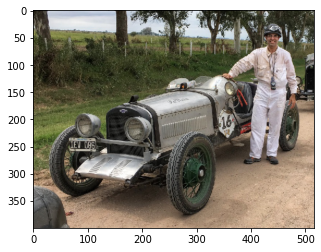

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


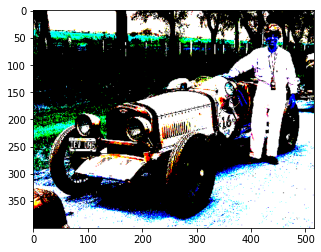

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


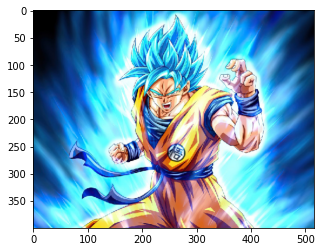

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


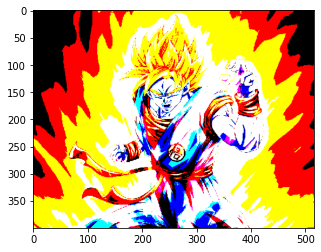

In [10]:
# get tensor representations of our images
# K.variable convierte un numpy array en un tensor, para 
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

In [11]:
combination_image = K.placeholder((1, img_nrows, img_ncols, 3))
print(combination_image.shape)

(1, 400, 516, 3)


Aclaración:

La siguiente celda sirve para procesar las tres imagenes (contenido, estilo y salida) en un solo batch.

In [12]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)
print(input_tensor.shape)

(3, 400, 516, 3)


In [13]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

print (model.summary())
# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])


Model loaded.
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None

# 4) En la siguientes celdas:

- ¿Qué es la matriz de Gram?¿Para qué se usa?

Una matriz de Gram es la matriz resultante de hacer el producto escalar de 2 vectores. En este paper lo que se hace es vectorizar los feature maps y hacer el producto escalar entre ambos. Se usa como parte del cálculo de la loss de estilo (style_loss) donde se minimiza la distancia cuadrática entre la matriz de Gram de la imagen original y de la imagen que es generada para mantener la representación del estilo.

- ¿Por qué se permutan las dimensiones de x?

Por un tema computacional, así las matrices de Gram quedan de 64x64, sino serían de 400x400, ahorrando espacio y reduciendo tiempos de procesamiento.


In [14]:
def gram_matrix(x):    
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    # y = K.permute_dimensions(x, (2, 0, 1))
    # print(x.shape)
    # print(y.shape)
    # print(features.shape)
    # print(gram.shape)
    return gram

# 5) Losses:

Explicar qué mide cada una de las losses en las siguientes tres celdas.

capas de la vgg19 https://www.programmersought.com/article/64074016754/

Rta:

**style_loss**
Calcula la loss de estilo tomando la distancia cuadrática entre la matriz de Gram del estilo para cada una de las capas de feature (block1_conv1','block2_conv1', 'block3_conv1', 'block4_conv1' y                   'block5_conv1) y la combinación que devuelve el feature block5_conv2.

**content_loss**
Calcula la loss de contenido tomando la distancia cuadrática entre la imagen y la combinación que devuelve el feature block5_conv2

**total_variation_loss**
Trabaja con el combination_feature de la capa de features block5_conv2. Recorta la imagen en 3 seccciones por canal (R, G, B): 

seccion1: desde [0, 0] hasta [filas-1, columnas-1]

sección2: desde [1, 0] hasta [filas, columnas-1]

sección3: desde [0, 1] hasta [filas-1, columnas]

luego calcula el cuadrado de la diferencia entre sección1 y sección2; y entre sección1 y sección3.
Y después suma ambos resultados y lo eleva a 1,25.

Esto lo hace para minimizar la diferencia entre los distintos puntos de la imagen para que no tenga cambios abruptos.

In [15]:
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [16]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))


In [17]:
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))


In [18]:
print (outputs_dict)

{'input_1': <tf.Tensor 'concat:0' shape=(3, 400, 516, 3) dtype=float32>, 'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 400, 516, 64) dtype=float32>, 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 400, 516, 64) dtype=float32>, 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 200, 258, 64) dtype=float32>, 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 200, 258, 128) dtype=float32>, 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 200, 258, 128) dtype=float32>, 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 100, 129, 128) dtype=float32>, 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 100, 129, 256) dtype=float32>, 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 100, 129, 256) dtype=float32>, 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 100, 129, 256) dtype=float32>, 'block3_conv4': <tf.Tensor 'block3_conv4/Relu:0' shape=(3, 100, 129, 256) dtype=float32>, 'block3_pool': <tf.Tensor 'b

In [19]:
# Armamos la loss total
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(base_image_features,
                                            combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :] 
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl
loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [20]:
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



# 6) Explique el propósito de las siguientes tres celdas. ¿Qué hace la función fmin_l_bfgs_b? ¿En qué se diferencia con la implementación del paper? ¿Se puede utilizar alguna alternativa?

Respuesta:

**Celda def eval_loss_and_grads(x)**

Devuelve la loss y el gradiente, f_outputs recibe una imagen y devuelve la loss y el gradiente

**Celda class Evaluator**

Define una clase con los métodos **loss** y **grads** que luego se va a utilizar en como parámetro para fmin_l_bfgs_b

En el **constructor** se inicializan los atributos loss_value y grad_value en none.

El método **loss** llama a la función eval_loss_and_grands y asigna el resultado en los atributos loss_value y grad_value, y devuelve solo el loss_value. Esta función es la que se minimiza en fmin_l_bfgs_b.

el método **grads** devuelve el valor del atributo grad_value y lo vuelve a setear en none, al igual que al atributo loss_value.

¿Qué hace la función fmin_l_bfgs_b?

Minimiza la loss usando el algoritmo L-BFGS-B. El algoritmo trabaja usando la matriz Hesiana y sirve para hacer una aproximación de la función por método de Newton cuando la función tiene muchos parámetros. Es más eficiente en terminos computacionales.

¿En qué se diferencia con la implementación del paper?

aa

¿Se puede utilizar alguna alternativa?

ss

In [21]:
def eval_loss_and_grads(x):
    x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.

In [22]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

# 7) Ejecute la siguiente celda y observe las imágenes de salida en cada iteración.

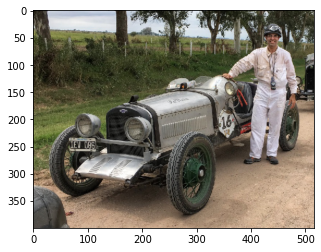

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


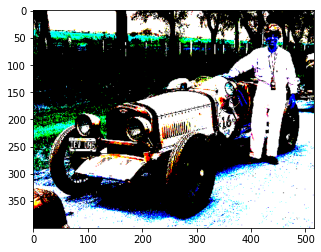

Start of iteration 0
Current loss value: 49220050000.0
Image saved as /content/drive/MyDrive/output_ndg/output_at_iteration_0.png
Iteration 0 completed in 20s
Start of iteration 1
Current loss value: 25412116000.0
Image saved as /content/drive/MyDrive/output_ndg/output_at_iteration_1.png
Iteration 1 completed in 15s
Start of iteration 2
Current loss value: 18381816000.0
Image saved as /content/drive/MyDrive/output_ndg/output_at_iteration_2.png
Iteration 2 completed in 15s
Start of iteration 3
Current loss value: 14673519000.0
Image saved as /content/drive/MyDrive/output_ndg/output_at_iteration_3.png
Iteration 3 completed in 15s
Start of iteration 4
Current loss value: 12223886000.0
Image saved as /content/drive/MyDrive/output_ndg/output_at_iteration_4.png
Iteration 4 completed in 15s
Start of iteration 5
Current loss value: 10684187000.0
Image saved as /content/drive/MyDrive/output_ndg/output_at_iteration_5.png
Iteration 5 completed in 15s
Start of iteration 6
Current loss value: 93078

In [23]:
evaluator = Evaluator()

# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_image(base_image_path)

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    fname = result_prefix / ('output_at_iteration_%d.png' % i)
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

# 8) Generar imágenes para distintas combinaciones de pesos de las losses. Explicar las diferencias. (Adjuntar las imágenes generadas como archivos separados.)

Respuesta:

# 9) Cambiar las imágenes de contenido y estilo por unas elegidas por usted. Adjuntar el resultado.

Respuesta: